<a href="https://colab.research.google.com/github/srujan-b/Assignment-2-Choose-Your-Own-Analysis/blob/main/Task1_isCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile

# Extracting ZIP file for the images and CSV file
with zipfile.ZipFile('/content/Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [ ]:
# Importing libraries

import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from tensorflow.keras import datasets, layers, models
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

In [ ]:
# reading the data from data_labels_mainData csv files 

data_main = pd.read_csv('/content/data_labels_mainData.csv')
data_main = data_main[['ImageName', 'isCancerous']]
data_main.head()

,ImageName,isCancerous
0,22405.png,0
1,22406.png,0
2,22407.png,0
3,22408.png,0
4,22409.png,0


In [ ]:
# reading the data from data_labels_extraData csv files 
data_extra = pd.read_csv('/content/data_labels_extraData.csv')
data_extra = data_extra[['ImageName', 'isCancerous']]
data_extra.head()

,ImageName,isCancerous
0,12681.png,0
1,12682.png,0
2,12683.png,0
3,12684.png,0
4,12685.png,0


In [ ]:
data = pd.concat([data_main, data_extra], axis=0)

data['isCancerous'] = data['isCancerous'].astype('str')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20280 entries, 0 to 10383
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ImageName    20280 non-null  object
 1   isCancerous  20280 non-null  object
dtypes: object(2)
memory usage: 475.3+ KB


# We will split the data such that 

 * 60 % for train data
 * 20 % for Validation 
 * 20 % for testing 

In [ ]:
#Splitting data into train, test and validation
train_data, test_data = train_test_split(data, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=0)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 12168, Val Data: 4056, Test Data: 4056


In [ ]:
val_data.shape

(4056, 2)

In [ ]:
train_datagen=ImageDataGenerator(zoom_range=0.1,shear_range=0.2,rescale=1/255,horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1/255)

In [ ]:
# Real time data augmentation 
batch_size = 32
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

valid_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


Test generator

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='/content/patch_images',
        
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27,27),
        batch_size=batch_size,
        class_mode='categorical')

Found 4056 validated image filenames belonging to 2 classes.


#Base Model

In [ ]:
#Creating new model and adding layers
baseModel= models.Sequential()
baseModel.add(Flatten(input_shape=(27,27,3)))
baseModel.add(Dense(256))
baseModel.add(Dense(2,activation='sigmoid'))

baseModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 256)               560128    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


In [ ]:
baseModel.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

baseModelHistory = baseModel.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)

<ipython-input-14-cced2f43e74a>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  baseModelHistory = baseModel.fit_generator(generator=train_generator,


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


380/380 [==============================] - 27s 57ms/step - loss: 0.7180 - accuracy: 0.7259 - val_loss: 0.4238 - val_accuracy: 0.7904
Epoch 2/10
380/380 [==============================] - 13s 34ms/step - loss: 0.4207 - accuracy: 0.8097 - val_loss: 0.6461 - val_accuracy: 0.7178
Epoch 3/10
380/380 [==============================] - 13s 34ms/step - loss: 0.4019 - accuracy: 0.8201 - val_loss: 0.3823 - val_accuracy: 0.8281
Epoch 4/10
380/380 [==============================] - 13s 34ms/step - loss: 0.3862 - accuracy: 0.8240 - val_loss: 0.3696 - val_accuracy: 0.8338
Epoch 5/10
380/380 [==============================] - 14s 36ms/step - loss: 0.3793 - accuracy: 0.8256 - val_loss: 0.3777 - val_accuracy: 0.8301
Epoch 6/10
380/380 [==============================] - 14s 37ms/step - loss: 0.3809 - accuracy: 0.8288 - val_loss: 0.3508 - val_accuracy: 0.8408
Epoch 7/10
380/380 [==============================] - 13s 34ms/step - loss: 0.3761 - accuracy: 0.8301 - val_loss: 0.3553 - val_accuracy: 0.8400
Epo

In [ ]:
baseModelHistory.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

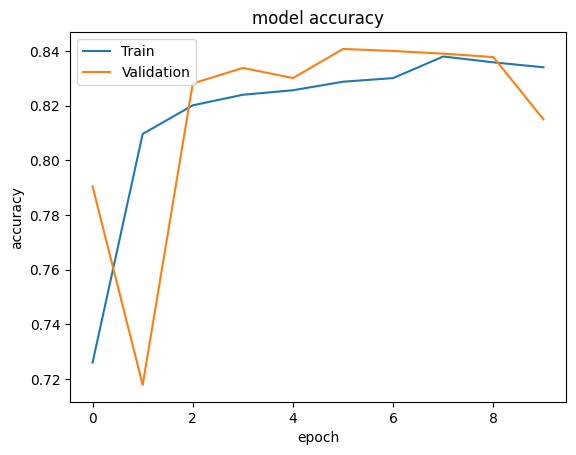

In [ ]:
plt.plot(baseModelHistory.history['accuracy'])
plt.plot(baseModelHistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.show()

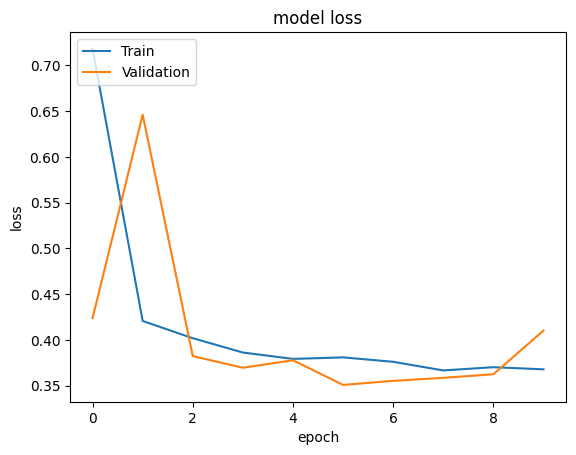

In [ ]:
plt.plot(baseModelHistory.history['loss'])
plt.plot(baseModelHistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.show()

In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
baseModel.evaluate_generator(generator=valid_generator,
steps=STEP_SIZE_TEST)

<ipython-input-18-c89c26900ddf>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  baseModel.evaluate_generator(generator=valid_generator,


[0.4092951714992523, 0.8152281641960144]

In [ ]:
acc = baseModel.evaluate(test_generator)[1]

print("The accuracy of our base model is "+ str(acc*100))

127/127 [==============================] - 2s 17ms/step - loss: 0.4180 - accuracy: 0.8052
The accuracy of our base model is 80.52268028259277


#Improving the model

In [ ]:
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization,GlobalAvgPool2D
from keras.models import Sequential

activationMidLayers = 'relu'
secondModel = models.Sequential()
secondModel.add(Conv2D(16, (3,3),activation = activationMidLayers, padding='same', input_shape = (27,27,3)))
secondModel.add(MaxPool2D(pool_size=(2,2)))
secondModel.add(Conv2D(32, (3,3), padding='same',activation = activationMidLayers))
secondModel.add(MaxPool2D(pool_size=(2,2)))
secondModel.add(Conv2D(64, (3,3), padding='same',activation = activationMidLayers))
secondModel.add(MaxPool2D(pool_size=(2,2)))
secondModel.add(Dropout(rate=0.25))
secondModel.add(Flatten())
secondModel.add(Dense(units=64,activation = activationMidLayers))
secondModel.add(Dropout(rate=0.25))
secondModel.add(Dense(units=2,activation = 'sigmoid'))


secondModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)        

In [ ]:
from sklearn import metrics
secondModel.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

#earlyStopping

earlyStopping = EarlyStopping(monitor='Val_accuracy',min_delta=0.01,patience=3,verbose=1,mode='auto')

#modelCheckpoint

modelAccuracy = ModelCheckpoint(monitor='Val_accuracy',filepath="./bestAccuracteModel.h5",verbose=1,save_best_only= True, mode='auto')

call =[earlyStopping,modelAccuracy]

In [ ]:
seconsModelHistory = secondModel.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50,
                    callbacks=call)

Epoch 1/50


<ipython-input-23-9a9107b4a77b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  seconsModelHistory = secondModel.fit_generator(generator=train_generator,


380/380 [==============================] - ETA: 0s - loss: 0.4631 - accuracy: 0.7770

380/380 [==============================] - 20s 37ms/step - loss: 0.4631 - accuracy: 0.7770 - val_loss: 0.3175 - val_accuracy: 0.8715
Epoch 2/50
379/380 [============================>.] - ETA: 0s - loss: 0.3497 - accuracy: 0.8529

380/380 [==============================] - 14s 38ms/step - loss: 0.3496 - accuracy: 0.8530 - val_loss: 0.3325 - val_accuracy: 0.8673
Epoch 3/50
379/380 [============================>.] - ETA: 0s - loss: 0.3274 - accuracy: 0.8661

380/380 [==============================] - 14s 38ms/step - loss: 0.3273 - accuracy: 0.8660 - val_loss: 0.2947 - val_accuracy: 0.8829
Epoch 4/50
380/380 [==============================] - ETA: 0s - loss: 0.3125 - accuracy: 0.8707

380/380 [==============================] - 14s 37ms/step - loss: 0.3125 - accuracy: 0.8707 - val_loss: 0.3151 - val_accuracy: 0.8671
Epoch 5/50
379/380 [============================>.] - ETA: 0s - loss: 0.3038 - accuracy: 0.8749

380/380 [==============================] - 14s 36ms/step - loss: 0.3039 - accuracy: 0.8748 - val_loss: 0.2894 - val_accuracy: 0.8832
Epoch 6/50
380/380 [==============================] - ETA: 0s - loss: 0.2968 - accuracy: 0.8762

380/380 [==============================] - 14s 36ms/step - loss: 0.2968 - accuracy: 0.8762 - val_loss: 0.2727 - val_accuracy: 0.8906
Epoch 7/50
379/380 [============================>.] - ETA: 0s - loss: 0.2982 - accuracy: 0.8743

380/380 [==============================] - 14s 38ms/step - loss: 0.2979 - accuracy: 0.8743 - val_loss: 0.2946 - val_accuracy: 0.8760
Epoch 8/50
379/380 [============================>.] - ETA: 0s - loss: 0.2935 - accuracy: 0.8795

380/380 [==============================] - 14s 38ms/step - loss: 0.2936 - accuracy: 0.8796 - val_loss: 0.3435 - val_accuracy: 0.8576
Epoch 9/50
379/380 [============================>.] - ETA: 0s - loss: 0.2869 - accuracy: 0.8802

380/380 [==============================] - 15s 38ms/step - loss: 0.2869 - accuracy: 0.8803 - val_loss: 0.3158 - val_accuracy: 0.8718
Epoch 10/50
380/380 [==============================] - ETA: 0s - loss: 0.2921 - accuracy: 0.8782

380/380 [==============================] - 14s 38ms/step - loss: 0.2921 - accuracy: 0.8782 - val_loss: 0.3003 - val_accuracy: 0.8748
Epoch 11/50
379/380 [============================>.] - ETA: 0s - loss: 0.2860 - accuracy: 0.8806

380/380 [==============================] - 14s 37ms/step - loss: 0.2862 - accuracy: 0.8804 - val_loss: 0.2859 - val_accuracy: 0.8790
Epoch 12/50
379/380 [============================>.] - ETA: 0s - loss: 0.2843 - accuracy: 0.8842

380/380 [==============================] - 13s 35ms/step - loss: 0.2841 - accuracy: 0.8843 - val_loss: 0.2795 - val_accuracy: 0.8919
Epoch 13/50
379/380 [============================>.] - ETA: 0s - loss: 0.2826 - accuracy: 0.8826

380/380 [==============================] - 13s 35ms/step - loss: 0.2824 - accuracy: 0.8827 - val_loss: 0.2736 - val_accuracy: 0.8911
Epoch 14/50
380/380 [==============================] - ETA: 0s - loss: 0.2770 - accuracy: 0.8909

380/380 [==============================] - 14s 36ms/step - loss: 0.2770 - accuracy: 0.8909 - val_loss: 0.2741 - val_accuracy: 0.8929
Epoch 15/50
380/380 [==============================] - ETA: 0s - loss: 0.2734 - accuracy: 0.8863

380/380 [==============================] - 14s 36ms/step - loss: 0.2734 - accuracy: 0.8863 - val_loss: 0.2691 - val_accuracy: 0.8936
Epoch 16/50
379/380 [============================>.] - ETA: 0s - loss: 0.2699 - accuracy: 0.8892

380/380 [==============================] - 15s 38ms/step - loss: 0.2700 - accuracy: 0.8893 - val_loss: 0.2674 - val_accuracy: 0.8936
Epoch 17/50
380/380 [==============================] - ETA: 0s - loss: 0.2667 - accuracy: 0.8905

380/380 [==============================] - 14s 37ms/step - loss: 0.2667 - accuracy: 0.8905 - val_loss: 0.2599 - val_accuracy: 0.8948
Epoch 18/50
379/380 [============================>.] - ETA: 0s - loss: 0.2682 - accuracy: 0.8933

380/380 [==============================] - 13s 35ms/step - loss: 0.2680 - accuracy: 0.8934 - val_loss: 0.2620 - val_accuracy: 0.8991
Epoch 19/50
379/380 [============================>.] - ETA: 0s - loss: 0.2629 - accuracy: 0.8928

380/380 [==============================] - 14s 38ms/step - loss: 0.2629 - accuracy: 0.8928 - val_loss: 0.2784 - val_accuracy: 0.8872
Epoch 20/50
379/380 [============================>.] - ETA: 0s - loss: 0.2604 - accuracy: 0.8956

380/380 [==============================] - 13s 35ms/step - loss: 0.2604 - accuracy: 0.8955 - val_loss: 0.2608 - val_accuracy: 0.8936
Epoch 21/50
379/380 [============================>.] - ETA: 0s - loss: 0.2608 - accuracy: 0.8941

380/380 [==============================] - 13s 35ms/step - loss: 0.2609 - accuracy: 0.8942 - val_loss: 0.2631 - val_accuracy: 0.8958
Epoch 22/50
379/380 [============================>.] - ETA: 0s - loss: 0.2580 - accuracy: 0.8962

380/380 [==============================] - 15s 39ms/step - loss: 0.2583 - accuracy: 0.8959 - val_loss: 0.2637 - val_accuracy: 0.8996
Epoch 23/50
380/380 [==============================] - ETA: 0s - loss: 0.2537 - accuracy: 0.8968

380/380 [==============================] - 14s 36ms/step - loss: 0.2537 - accuracy: 0.8968 - val_loss: 0.2689 - val_accuracy: 0.8921
Epoch 24/50
380/380 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.8962

380/380 [==============================] - 14s 37ms/step - loss: 0.2543 - accuracy: 0.8962 - val_loss: 0.2964 - val_accuracy: 0.8829
Epoch 25/50
379/380 [============================>.] - ETA: 0s - loss: 0.2470 - accuracy: 0.9015

380/380 [==============================] - 13s 35ms/step - loss: 0.2477 - accuracy: 0.9012 - val_loss: 0.2593 - val_accuracy: 0.8963
Epoch 26/50
380/380 [==============================] - ETA: 0s - loss: 0.2482 - accuracy: 0.8982

380/380 [==============================] - 13s 35ms/step - loss: 0.2482 - accuracy: 0.8982 - val_loss: 0.3006 - val_accuracy: 0.8718
Epoch 27/50
380/380 [==============================] - ETA: 0s - loss: 0.2464 - accuracy: 0.8987

380/380 [==============================] - 13s 35ms/step - loss: 0.2464 - accuracy: 0.8987 - val_loss: 0.2550 - val_accuracy: 0.9010
Epoch 28/50
380/380 [==============================] - ETA: 0s - loss: 0.2412 - accuracy: 0.9011

380/380 [==============================] - 13s 35ms/step - loss: 0.2412 - accuracy: 0.9011 - val_loss: 0.2707 - val_accuracy: 0.8919
Epoch 29/50
379/380 [============================>.] - ETA: 0s - loss: 0.2358 - accuracy: 0.9047

380/380 [==============================] - 14s 38ms/step - loss: 0.2357 - accuracy: 0.9047 - val_loss: 0.2557 - val_accuracy: 0.8978
Epoch 30/50
380/380 [==============================] - ETA: 0s - loss: 0.2352 - accuracy: 0.9051

380/380 [==============================] - 14s 38ms/step - loss: 0.2352 - accuracy: 0.9051 - val_loss: 0.2608 - val_accuracy: 0.9003
Epoch 31/50
379/380 [============================>.] - ETA: 0s - loss: 0.2313 - accuracy: 0.9052

380/380 [==============================] - 14s 38ms/step - loss: 0.2313 - accuracy: 0.9052 - val_loss: 0.2639 - val_accuracy: 0.8968
Epoch 32/50
380/380 [==============================] - ETA: 0s - loss: 0.2385 - accuracy: 0.9005

380/380 [==============================] - 14s 38ms/step - loss: 0.2385 - accuracy: 0.9005 - val_loss: 0.2641 - val_accuracy: 0.8986
Epoch 33/50
379/380 [============================>.] - ETA: 0s - loss: 0.2296 - accuracy: 0.9074

380/380 [==============================] - 13s 35ms/step - loss: 0.2299 - accuracy: 0.9074 - val_loss: 0.2554 - val_accuracy: 0.8993
Epoch 34/50
379/380 [============================>.] - ETA: 0s - loss: 0.2275 - accuracy: 0.9095

380/380 [==============================] - 13s 35ms/step - loss: 0.2275 - accuracy: 0.9094 - val_loss: 0.2601 - val_accuracy: 0.8976
Epoch 35/50
380/380 [==============================] - ETA: 0s - loss: 0.2248 - accuracy: 0.9113

380/380 [==============================] - 13s 35ms/step - loss: 0.2248 - accuracy: 0.9113 - val_loss: 0.2621 - val_accuracy: 0.8946
Epoch 36/50
379/380 [============================>.] - ETA: 0s - loss: 0.2207 - accuracy: 0.9089

380/380 [==============================] - 14s 38ms/step - loss: 0.2213 - accuracy: 0.9085 - val_loss: 0.2555 - val_accuracy: 0.9010
Epoch 37/50
379/380 [============================>.] - ETA: 0s - loss: 0.2303 - accuracy: 0.9046

380/380 [==============================] - 14s 38ms/step - loss: 0.2303 - accuracy: 0.9044 - val_loss: 0.2675 - val_accuracy: 0.8998
Epoch 38/50
380/380 [==============================] - ETA: 0s - loss: 0.2197 - accuracy: 0.9114

380/380 [==============================] - 14s 36ms/step - loss: 0.2197 - accuracy: 0.9114 - val_loss: 0.2760 - val_accuracy: 0.8966
Epoch 39/50
379/380 [============================>.] - ETA: 0s - loss: 0.2151 - accuracy: 0.9146

380/380 [==============================] - 14s 38ms/step - loss: 0.2152 - accuracy: 0.9145 - val_loss: 0.2524 - val_accuracy: 0.9025
Epoch 40/50
380/380 [==============================] - ETA: 0s - loss: 0.2179 - accuracy: 0.9130

380/380 [==============================] - 15s 38ms/step - loss: 0.2179 - accuracy: 0.9130 - val_loss: 0.2684 - val_accuracy: 0.8938
Epoch 41/50
379/380 [============================>.] - ETA: 0s - loss: 0.2129 - accuracy: 0.9158

380/380 [==============================] - 14s 37ms/step - loss: 0.2127 - accuracy: 0.9160 - val_loss: 0.2650 - val_accuracy: 0.8978
Epoch 42/50
380/380 [==============================] - ETA: 0s - loss: 0.2087 - accuracy: 0.9158

380/380 [==============================] - 15s 38ms/step - loss: 0.2087 - accuracy: 0.9158 - val_loss: 0.2532 - val_accuracy: 0.9033
Epoch 43/50
380/380 [==============================] - ETA: 0s - loss: 0.2127 - accuracy: 0.9164

380/380 [==============================] - 13s 35ms/step - loss: 0.2127 - accuracy: 0.9164 - val_loss: 0.2530 - val_accuracy: 0.9023
Epoch 44/50
380/380 [==============================] - ETA: 0s - loss: 0.2059 - accuracy: 0.9174

380/380 [==============================] - 15s 38ms/step - loss: 0.2059 - accuracy: 0.9174 - val_loss: 0.2819 - val_accuracy: 0.8857
Epoch 45/50
379/380 [============================>.] - ETA: 0s - loss: 0.2044 - accuracy: 0.9185

380/380 [==============================] - 14s 36ms/step - loss: 0.2046 - accuracy: 0.9185 - val_loss: 0.2654 - val_accuracy: 0.8968
Epoch 46/50
380/380 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.9165

380/380 [==============================] - 14s 38ms/step - loss: 0.2069 - accuracy: 0.9165 - val_loss: 0.2666 - val_accuracy: 0.9030
Epoch 47/50
379/380 [============================>.] - ETA: 0s - loss: 0.2053 - accuracy: 0.9189

380/380 [==============================] - 14s 38ms/step - loss: 0.2050 - accuracy: 0.9189 - val_loss: 0.2758 - val_accuracy: 0.9035
Epoch 48/50
380/380 [==============================] - ETA: 0s - loss: 0.1953 - accuracy: 0.9206

380/380 [==============================] - 13s 35ms/step - loss: 0.1953 - accuracy: 0.9206 - val_loss: 0.2829 - val_accuracy: 0.8983
Epoch 49/50
379/380 [============================>.] - ETA: 0s - loss: 0.2038 - accuracy: 0.9185

380/380 [==============================] - 14s 38ms/step - loss: 0.2035 - accuracy: 0.9187 - val_loss: 0.2597 - val_accuracy: 0.8958
Epoch 50/50
379/380 [============================>.] - ETA: 0s - loss: 0.1907 - accuracy: 0.9237

380/380 [==============================] - 14s 37ms/step - loss: 0.1905 - accuracy: 0.9238 - val_loss: 0.2665 - val_accuracy: 0.9033


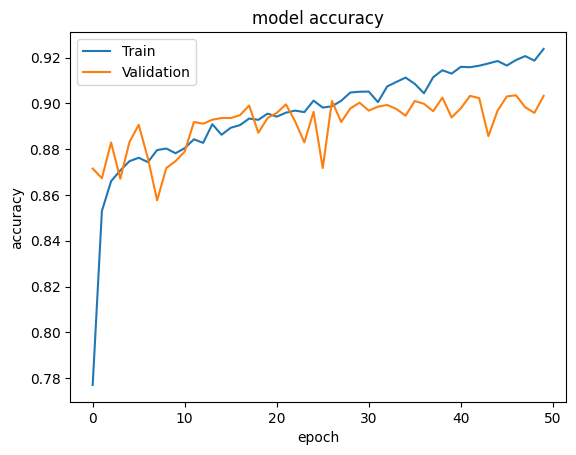

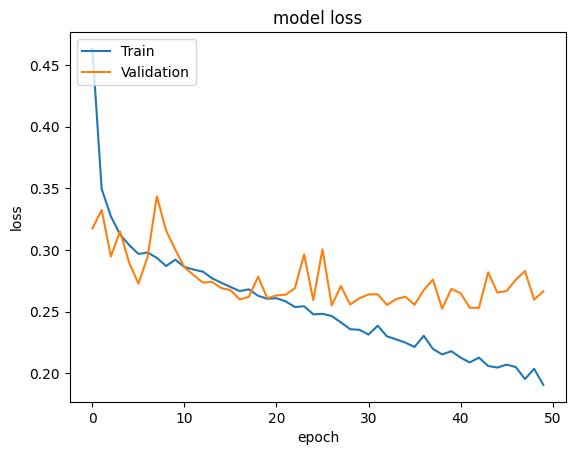

In [ ]:
seconsModelHistory.history.keys()
plt.plot(seconsModelHistory.history['accuracy'])
plt.plot(seconsModelHistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.show()
plt.plot(seconsModelHistory.history['loss'])
plt.plot(seconsModelHistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.show()

In [ ]:
# model accuracy
secondModel.evaluate(train_generator)
secondModel.evaluate(valid_generator)
secondModel.evaluate(test_generator)

127/127 [==============================] - 2s 14ms/step - loss: 0.2838 - accuracy: 0.8923


[0.2838035225868225, 0.8922584056854248]